In [1]:
from vedo import Volume, Text2D, show

In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

/home/sobhan/miniconda3/envs/ml-dl/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from minisurf.trig import Gyroid

In [4]:
gyroid = Gyroid()
gyroid(1,1,1)

-7.347880794884119e-16

In [5]:
gyroid = Gyroid()
gyroid(x=1,y=1,z=1,  ax=1,bx=1,cx=2)

-9.797174393178826e-16

In [6]:
from itertools import product

In [7]:
len(list (product([1,2,3], repeat=3)))

27

In [8]:
# for x, y, z in product(np.linspace(0.0, 1, 10), repeat=3):
#     print(gyroid(x,y,z))

In [9]:
x, y, z= 0.5, 1, 0.5
for ax, bx, cx in product([1,2,], repeat=3):
    print(gyroid(x,y,z, ax,bx,cx))

2.449293598294706e-16
1.224646799147353e-16
4.898587196589413e-16
3.67394039744206e-16
3.6739403974420594e-16
2.4492935982947064e-16
6.123233995736765e-16
4.898587196589412e-16


In [10]:
len(list (product(np.linspace(0.0, 1, 8), repeat=3)))

512

In [11]:
data   = []
target = []
for  ax, bx, cx in product(np.array([1,2,]), repeat=3):
    for x, y, z in product(np.linspace(0.0, 1, 15), repeat=3):
        # print( ax, bx, cx)
        data = data + [[x,y,z, ax,bx,cx]]
        target = target + [gyroid(x,y,z, ax,bx,cx)]
    

In [12]:
# target

In [13]:
# box_siz = 24
# num_samples = 1000   # sample data number
# rand_radious= torch.randint(3, 150, (num_samples,))/10 # create a random array of raduis
# features = box(radius=rand_radious, box_size=box_siz)  # data set

In [14]:
features = torch.tensor(data)

In [15]:
features.shape

torch.Size([27000, 6])

In [16]:
features[5]

tensor([0.0000, 0.0000, 0.3571, 1.0000, 1.0000, 1.0000], dtype=torch.float64)

In [17]:
# import pandas as pd
# _ = pd.DataFrame(features.detach().numpy(), columns=["x", "y", "z", "ax", "bx", "cx"]).hist()

In [18]:
meaan = torch.mean(features, axis=0)
sttd = torch.std(features, axis=0)
features = (features - meaan)/sttd

In [19]:
labels = torch.tensor(target)

In [20]:
labels = labels/labels.max()

In [21]:
# import pandas as pd
# _ = pd.DataFrame(features.detach().numpy(), columns=["x", "y", "z", "ax", "bx", "cx"]).hist()

In [22]:
input_dim = 3  # x, y, z poisitons of one pixel
hidden_dim = 40 # this one is so decisive

In [23]:
# defining dropout_layer
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        is_training = True
#         self.func1 = nn.Linear(input_dim + code.shape[1], hidden_dim)
        # code len is = 3
        self.func1 = nn.Linear(input_dim + 3, hidden_dim)

        self.func2 = nn.Linear(hidden_dim, hidden_dim)
        self.func3 = nn.Linear(hidden_dim, hidden_dim)
        self.func4 = nn.Linear(hidden_dim, hidden_dim)
        self.func5 = nn.Linear(hidden_dim, 1)
        
        self.outp = nn.Tanh()
        
                
                
    def forward(self, x):
#         z = torch.cat((x, code_), axis=0)
        z = nn.functional.relu(self.func1(x.float()))
#         return self.outp(self.func5(z))
            # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            z = dropout_layer(z, dropout=0.080)
#         return self.outp(self.func5(z))    
        z = nn.functional.relu(self.func2(z.float()))
        
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            z = dropout_layer(z, dropout=0.10)
        
        z = nn.functional.relu(self.func3(z))
        
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            z = dropout_layer(z, dropout=0.10)
        
        z = nn.functional.relu(self.func4(z))
        
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            z = dropout_layer(z, dropout=0.10)
        
        z = self.func5(z)
#         z = self.func5(z)
        
        
        return self.outp(z)

In [25]:
model = Model()

In [26]:
# labels = labels.reshape(-1,1)

In [27]:
labels.shape

torch.Size([27000])

In [28]:
# features[1250]

In [29]:
model(features[20])

tensor([-0.1428], grad_fn=<TanhBackward0>)

In [30]:
# torch.cat((a, b), axis=0)

In [31]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True): #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [32]:
# for i in range(features[0].shape[0]):
#     for j in range(features[0].shape[1]):
#         print(model(features[0][i][j]))

In [33]:
train_x = features[:-features.shape[0]*20//100]
test_x  = features[-features.shape[0]*20//100:]
train_y = labels[:-labels.shape[0]*20//100]
test_y  = labels[-labels.shape[0]*20//100:]

batch_size = test_x.shape[0]

print(f'x train size= {train_x.shape}, test size= {test_x.shape}, batch size= {batch_size}')
print(f'y train size= {train_y.shape}, test size= {test_y.shape}, batch size= {batch_size}')
train_loader = load_array((train_x, train_y), batch_size)
test_loader  = load_array((test_x, test_y), batch_size)

x train size= torch.Size([21600, 6]), test size= torch.Size([5400, 6]), batch size= 5400
y train size= torch.Size([21600]), test size= torch.Size([5400]), batch size= 5400


In [34]:
model.parameters()

<generator object Module.parameters at 0x7f64f33f72e0>

In [35]:
# hyperparameters

lr = 2e-2

epochs = 300
DEVICE = 'cpu'
print_step = 50

In [36]:
# features[:-20].shape, features[-20:].shape

In [37]:
# we want to allow only 20% of data for test and the rest on training data
features.shape[0]*20//100

5400

In [38]:
# 80% for traning test, and 20% for test


In [39]:
train_x.shape, test_x.shape

(torch.Size([21600, 6]), torch.Size([5400, 6]))

# Training

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

In [41]:
# torch.randn(3, 5).softmax(dim=1), torch.randn(3, 5)

In [42]:
# loss = nn.CrossEntropyLoss(reduction='none')
# def loss(y_hat, y):
#     return (y_hat-y).sum()
loss = nn.MSELoss()
# loss = nn.CrossEntropyLoss()
# loss = nn.BCEWithLogitsLoss()


In [43]:
# num_epochs = 30
# for epoch in range(num_epochs):
#     for X,Y in train_loader:
#     #     print(X,Y)
# #         x = X.T
# #         y = Y
#         print(X.shape,Y.shape, model(X.float()).shape)
#         l = loss(model(X.float())[:,0], Y.float())
#         optimizer.zero_grad()
#         l.backward()
#         optimizer.step() #optimizer
# #     l = loss(model(x_truth.float()), y_truth.float())
# #     print(f'epoch {epoch + 1}, loss {l:f}')

In [44]:

print("Start training ...")
model.train()

for epoch in range(50):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_hat = model(x.float()).float()
        ll = loss(y_hat.flatten(), y.float().flatten())
        overall_loss += ll.item()
        ll.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    print(overall_loss)
    
print("Finish!!")


Start training ...
	Epoch 1 complete! 	Average Loss:  6.65758596158322e-05
1.0785289257764816
	Epoch 2 complete! 	Average Loss:  5.016573049404003e-05
0.8126848340034485
	Epoch 3 complete! 	Average Loss:  4.855421406251413e-05
0.7865782678127289
	Epoch 4 complete! 	Average Loss:  4.844825392887916e-05
0.7848617136478424
	Epoch 5 complete! 	Average Loss:  4.823498335885413e-05
0.7814067304134369
	Epoch 6 complete! 	Average Loss:  4.814285738968555e-05
0.7799142897129059
	Epoch 7 complete! 	Average Loss:  4.8176582764696194e-05
0.7804606407880783
	Epoch 8 complete! 	Average Loss:  4.8089782580917265e-05
0.7790544778108597
	Epoch 9 complete! 	Average Loss:  4.8094153588200796e-05
0.7791252881288528
	Epoch 10 complete! 	Average Loss:  4.811520101847472e-05
0.7794662564992905
	Epoch 11 complete! 	Average Loss:  4.808446967307432e-05
0.778968408703804
	Epoch 12 complete! 	Average Loss:  4.8086244015046105e-05
0.778997153043747
	Epoch 13 complete! 	Average Loss:  4.808469686979129e-05
0.77897

In [45]:
model(features[200])

tensor([0.1930], grad_fn=<TanhBackward0>)

In [46]:
# for p in model.parameters():
#     print(p)

In [47]:
for m in model.named_children():
    print(m)

('func1', Linear(in_features=6, out_features=40, bias=True))
('func2', Linear(in_features=40, out_features=40, bias=True))
('func3', Linear(in_features=40, out_features=40, bias=True))
('func4', Linear(in_features=40, out_features=40, bias=True))
('func5', Linear(in_features=40, out_features=1, bias=True))
('outp', Tanh())


In [48]:
model.func1.weight.requires_grad = False
model.func1.bias.requires_grad = False

model.func2.weight.requires_grad = False
model.func2.bias.requires_grad = False

model.func3.weight.requires_grad = False
model.func3.bias.requires_grad = False

model.func4.weight.requires_grad = False
model.func4.bias.requires_grad = False

model.func5.weight.requires_grad = False
model.func5.bias.requires_grad = False


In [49]:
model.func1.weight.requires_grad

False

In [50]:
# torch.tensor(code [0], requires_grad=True)

In [51]:
features[0].shape

torch.Size([6])

In [52]:
# x = torch.tensor(features[0][:2])
# codee = torch.tensor(code [0], requires_grad=True)
# print(x.shape, codee.shape)
# j = torch.cat((x, codee), axis=0)
# j
# model(j)

In [53]:
model.parameters

<bound method Module.parameters of Model(
  (func1): Linear(in_features=6, out_features=40, bias=True)
  (func2): Linear(in_features=40, out_features=40, bias=True)
  (func3): Linear(in_features=40, out_features=40, bias=True)
  (func4): Linear(in_features=40, out_features=40, bias=True)
  (func5): Linear(in_features=40, out_features=1, bias=True)
  (outp): Tanh()
)>

In [54]:
# features

In [55]:
# code

In [56]:
# (num_samples)/box_siz

In [57]:
features[0], features[124], features[250]

(tensor([-1.6202, -1.6202, -1.6202, -1.0000, -1.0000, -1.0000],
        dtype=torch.float64),
 tensor([-1.6202,  0.2315, -0.6944, -1.0000, -1.0000, -1.0000],
        dtype=torch.float64),
 tensor([-1.3887, -1.3887,  0.6944, -1.0000, -1.0000, -1.0000],
        dtype=torch.float64))

In [58]:
# step = int((num_samples//2)/box_siz)
# num_distic_codes = step

In [59]:
# step

In [60]:
optim_code = torch.empty(3)
optim_code.shape

torch.Size([3])

In [61]:
features[0:6]

tensor([[-1.6202, -1.6202, -1.6202, -1.0000, -1.0000, -1.0000],
        [-1.6202, -1.6202, -1.3887, -1.0000, -1.0000, -1.0000],
        [-1.6202, -1.6202, -1.1573, -1.0000, -1.0000, -1.0000],
        [-1.6202, -1.6202, -0.9258, -1.0000, -1.0000, -1.0000],
        [-1.6202, -1.6202, -0.6944, -1.0000, -1.0000, -1.0000],
        [-1.6202, -1.6202, -0.4629, -1.0000, -1.0000, -1.0000]],
       dtype=torch.float64)

In [62]:
# # for k in range(0, num_samples, step):
#     # for each code
#     # codee = torch.tensor(code [k])#, requires_grad=True)      
# for epoch in range(100):
#     overall_loss = 0
#     # int((num_samples//2)/box_siz)
#     for feat, label in zip(features, labels):
#         optimizer.zero_grad()
#         # xx = torch.tensor(features[i])
#         # x = xx.clone()
#         # print(x.shape, codee.shape)
#         # X = torch.cat((x, codee), axis=0)
#         # X = torch.cat((features[i], codee))
#         # X = torch.tensor(features[i], requires_grad=True)
#         codee = feat[3:]
#         print('before:', codee)
        
#         x = feat.clone()
#         X = torch.tensor([x[0], x[1], x[2], codee[0],codee[1], codee[2]] ,
#                          requires_grad=True )
#         # X = torch.tensor([x[0], x[1], codee[0], codee[1]], requires_grad=True )
#         # print(features[i])
#         # print(X.shape)
#         # features[i].requires_grad = True
#         y_hat = model(X.float()).float()
#         l = loss(y_hat, label.float())
#         # print(l)
#         overall_loss += l.item()
#         l.backward()
#         # print('x grad=',X.grad)
#         # optimizer.step()
#         # print(X.grad)
#         # print(X)
#         X = X -X.grad*0.02/100
#         # print(X-features[i])
#         codee = torch.tensor(X[3:], requires_grad=True )

#         # print(features[i])
#         # codee = torch.tensor([X[2], x[3]], requires_grad=True)
#         # codee = X[2:3] # only one
#         # print('*'*100)
#     # print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
#     # print(overall_loss)
#     print('after:', codee)
#     print('='*40)
#     # optim_code[k:k+step] = codee
# print("Finish!!")

In [63]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [64]:
from vedo import Volume, Text2D, show

In [65]:
def visulaize_volume(ax=1, bx=1, cx=1, step_size = 15):

    
    sc = np.empty((step_size, step_size, step_size))
    for idx, x in enumerate(np.linspace(0.0, 1, step_size)):
        for idy, y in enumerate(np.linspace(0.0, 1, step_size)):
            for idz, z in enumerate(np.linspace(0.0, 1, step_size)):
                inp = (torch.tensor([x,y,z,  ax,bx,cx]) - meaan)/sttd
                sc[idx, idy, idz]=model(inp)
   
    vol = Volume(sc)
    # print(vol.tonumpy)
    vol.add_scalarbar3d()
    # print('numpy array from Volume:', vol.tonumpy().shape)

    lego = vol.legosurface(vmin=0, vmax=3) # volume of sdf( g(x,y,z) ) > 0
    lego.cmap('hot_r', vmin=0, vmax=3).add_scalarbar3d()

    text1 = Text2D(__doc__, c='blue')
    text2 = Text2D('..and its lego isosurface representation\nvmin=1, vmax=2', c='dr')

    show([(vol,text1), (lego,text2)], N=2, azimuth=10)
      

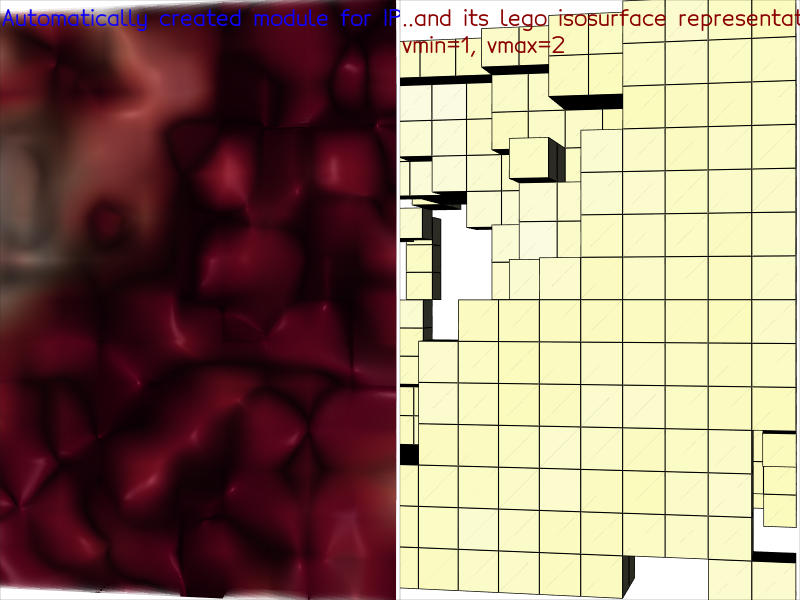

In [66]:
visulaize_volume(ax=1, bx=1, cx=1, step_size=15)

In [67]:
# visulaize_volume(apply_fun=model, ax=4, bx=1, cx=1.5, step_size=30)

In [68]:
float(model(features[0]))

0.19301597774028778